# Notebook Contents

- [Imports](#Imports)
- [Data](#Data)
- [Data Cleaning](#Data-Cleaning)
- [Preprocessing](#Preprocessing)
    - [Multicolinearity - VIF](#Multicolinearity---VIF)
- [Features](#Features)
- [Linear Regression](#Linear-Regression-Model)

# Imports

In [1]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from matplotlib.patches import Rectangle

import warnings
warnings.filterwarnings('ignore')

# Data

In [21]:
data = pd.read_csv('../data/model-pitches-rv.csv', index_col = [0])
data.drop(columns = ['plate_x', 'release_pos_x'], inplace = True)
data.rename(columns = {'pfx_-x': 'pfx_x', 
                       'plate_-x': 'plate_x', 
                       'release_pos_-x': 'release_pos_x'}, 
            inplace = True)
data['rv_rel_outs'] = round(data['rv_rel_outs'], 3)
pd.set_option('max_columns', None)
print(data.shape)
data.head()

(705396, 69)


,player_name,p_throws,pitch_type,velo,spin_rate,spin_axis,pfx_x,pfx_z,bauer_units,effective_speed,release_pos_x,release_pos_z,release_extension,release_pos_y,plate_x,plate_z,type,balls,strikes,pitch_count,delta_run_exp,stand,bb_type,description,events,hit_distance_sc,exit_velo,launch_angle,launch_speed_angle,woba_value,woba_denom,xba,xwobacon,babip_value,iso_value,at_bat_number,pitch_number,inning,inning_topbot,home_score,away_score,post_home_score,post_away_score,on_1b,on_2b,on_3b,outs_when_up,is_strike,is_ball,final_pitch_ab,out_to_end_inning,home_runs,away_runs,runs,re,re_change,re_end_state,re24,lin_weight_above_avg,lin_weight_above_outs,woba_scale,lin_weights_above_avg_scale,lin_weights_above_outs_scale,woba,wraa_change,count_re,bs_lin_weight,rv_rel_outs,rv
0,"Smith, Will",L,FF,92.3,2330.0,148.0,-8.28,16.56,25.243770,92.8,-1.40,6.80,6.5,54.03,0.69,2.83,X,1,2,1-2,-0.073,R,ground_ball,hit_into_play,field_out,13.0,95.2,-13.0,2.0,0.0,1.0,0.174,0.158,0.0,0.0,61,4,9,0,5,0,5,0,0,0,0,2,1,0,1,1,0,0,0,0.098,-0.098,0.000,-0.098,-0.25,0.0,1.209,-0.207,-0.067,0.223,-0.184,-0.184,-0.067,-0.067,-0.207
1,"Smith, Will",L,SL,80.6,2254.0,315.0,9.24,5.76,27.965261,81.2,-1.60,6.64,6.4,54.15,0.71,2.62,S,1,1,1-1,-0.027,R,NaN,strike,NaN,108.0,75.3,75.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,61,3,9,0,5,0,5,0,0,0,0,2,1,0,0,0,0,0,0,0.098,0.000,0.098,0.000,NaN,NaN,1.209,0.013,0.013,0.293,-0.058,-0.058,0.013,0.013,0.013
2,"Smith, Will",L,CU,75.5,1940.0,328.0,7.80,-6.12,25.695364,75.2,-1.46,6.88,6.2,54.34,0.04,2.46,S,1,0,1-0,-0.020,R,NaN,strike,NaN,157.0,83.5,65.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,61,2,9,0,5,0,5,0,0,0,0,2,1,0,0,0,0,0,0,0.098,0.000,0.098,0.000,NaN,NaN,1.209,0.018,0.018,0.355,-0.051,-0.051,0.018,0.018,0.018
3,"Smith, Will",L,CU,75.0,2017.0,330.0,8.28,-8.28,26.893333,74.5,-1.53,6.83,5.9,54.61,-2.10,3.89,B,0,0,0-0,0.016,R,NaN,ball,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,61,1,9,0,5,0,5,0,0,0,0,2,0,1,0,0,0,0,0,0.098,0.000,0.098,0.000,NaN,NaN,1.209,0.008,0.008,0.314,0.034,0.034,0.008,0.008,0.008
4,"Smith, Will",L,FF,91.2,2281.0,143.0,-7.56,15.36,25.010965,90.9,-1.49,6.66,6.3,54.15,0.31,2.80,X,1,0,1-0,-0.189,L,ground_ball,hit_into_play,field_out,9.0,93.3,-18.0,2.0,0.0,1.0,0.100,0.090,0.0,0.0,60,2,9,0,5,0,5,0,0,0,0,1,1,0,1,0,0,0,0,0.254,-0.156,0.098,-0.156,-0.25,0.0,1.209,-0.207,0.018,0.355,-0.051,-0.051,0.018,0.018,-0.207


Using this wOBA by count, we can calculate the value of points scored by count.

(count wOBA after pitching – count wOBA before pitching) / wOBAscale (≈1.15 in Statcast csv data)

First, when the count changes, the actual RAA is calculated as:

(wOBA of the count after the pitch – wOBA of the count before the pitch) / 1.15

If a batted ball occurs, then this is used to calculate RAA:

(xwOBAvalue – wOBA of the count before the pitch) / wOBAscale

# Cleaning / EDA

### Features

In [65]:
features = data[['player_name', 'p_throws', 'pitch_type', 'velo', 'spin_rate', 
                 'pfx_x', 'pfx_z', 'release_pos_x', 'release_pos_z', 'release_extension',
                  'plate_x', 'plate_z', 'bauer_units', 'rv_rel_outs']]

#'plate_x', 'plate_z',

# rv_rel_outs

# 'release_extension', 'stand'

In [66]:
ff = features.loc[features['pitch_type'] == 'FF']
fc = features.loc[features['pitch_type'] == 'FC']
fastball = ff.append(fc)
si = features.loc[features['pitch_type'] == 'SI']
fastball = fastball.append(si)
print('Fastball shape:', fastball.shape)
sl = features.loc[features['pitch_type'] == 'SL']
cu = features.loc[features['pitch_type'] == 'CU']
breaking_ball = sl.append(cu)
kc = features.loc[features['pitch_type'] == 'KC']
breaking_ball = breaking_ball.append(kc)
print('Breaking Ball:', breaking_ball.shape)
ch = features.loc[features['pitch_type'] == 'CH']
fs = features.loc[features['pitch_type'] == 'FS']
offspeed = ch.append(fs)
print('Off speed shape:', offspeed.shape)
rhp = features.loc[features['p_throws'] == 'R']
print('RHP shape:', rhp.shape)
lhp = features.loc[features['p_throws'] == 'L']
print('LHP shape:', lhp.shape)
#rhp_rhh = features.loc[(features['p_throws'] == 'R') & (features['stand'] == 'R')]
#print('RHP & RHH shape:', rhp_rhh.shape)
#rhp_lhh = features.loc[(features['p_throws'] == 'R') & (features['stand'] == 'L')]
#print('RHP & LHH shape:', rhp_lhh.shape)
#lhp_rhh = features.loc[(features['p_throws'] == 'L') & (features['stand'] == 'R')]
#print('LHP & RHH shape:', lhp_rhh.shape)
#lhp_lhh = features.loc[(features['p_throws'] == 'L') & (features['stand'] == 'L')]
#print('LHP & LHH shape:', lhp_lhh.shape)
rhp_fastball = fastball.loc[fastball['p_throws'] == 'R']
print('RHP Fastball shape:', rhp_fastball.shape)
lhp_fastball = fastball.loc[fastball['p_throws'] == 'L']
print('LHP Fastball shape:', lhp_fastball.shape)
rhp_breaking_ball = breaking_ball.loc[breaking_ball['p_throws'] == 'R']
print('RHP Breaking Ball shape:', rhp_breaking_ball.shape)
lhp_breaking_ball = breaking_ball.loc[breaking_ball['p_throws'] == 'L']
print('LHP Breaking Ball shape:', lhp_breaking_ball.shape)
rhp_offspeed = offspeed.loc[offspeed['p_throws'] == 'R']
print('RHP Offspeed shape:', rhp_offspeed.shape)
lhp_offspeed = offspeed.loc[offspeed['p_throws'] == 'L']
print('LHP Offspeed shape:', lhp_offspeed.shape)
ff_r = rhp.loc[rhp['pitch_type'] == 'FF']
ff_l = lhp.loc[lhp['pitch_type'] == 'FF']
fc_r = rhp.loc[rhp['pitch_type'] == 'FC']
fc_l = lhp.loc[lhp['pitch_type'] == 'FC']
si_r = rhp.loc[rhp['pitch_type'] == 'SI']
si_l = lhp.loc[lhp['pitch_type'] == 'SI']
sl_r = rhp.loc[rhp['pitch_type'] == 'SL']
sl_l = lhp.loc[lhp['pitch_type'] == 'SL']
cu_r = rhp.loc[rhp['pitch_type'] == 'CU']
cu_l = lhp.loc[lhp['pitch_type'] == 'CU']
ch_r = rhp.loc[rhp['pitch_type'] == 'CH']
ch_l = lhp.loc[lhp['pitch_type'] == 'CH']

Fastball shape: (406259, 14)
Breaking Ball: (207975, 14)
Off speed shape: (91162, 14)
RHP shape: (496493, 14)
LHP shape: (208903, 14)
RHP Fastball shape: (283224, 14)
LHP Fastball shape: (123035, 14)
RHP Breaking Ball shape: (152378, 14)
LHP Breaking Ball shape: (55597, 14)
RHP Offspeed shape: (60891, 14)
LHP Offspeed shape: (30271, 14)


In [67]:
data.groupby(['player_name', 'pitch_type'], as_index = False)['rv', 'rv_rel_outs'].sum()

,player_name,pitch_type,rv,rv_rel_outs
0,"Abad, Fernando",CH,-1.589,0.491
1,"Abad, Fernando",FC,0.277,1.162
2,"Abad, Fernando",FF,1.912,3.063
3,"Abad, Fernando",KC,0.560,4.331
4,"Abad, Fernando",SI,0.203,7.327
...,...,...,...,...
3462,"Álvarez, José",CH,-6.291,6.438
3463,"Álvarez, José",FC,-0.081,0.473
3464,"Álvarez, José",FF,-1.567,4.062
3465,"Álvarez, José",SI,-7.303,14.885


In [68]:
data.groupby(['events'], as_index = False)['re24', 'rv'].mean()

,events,re24,rv
0,double,0.765841,0.634
1,field_error,0.427661,0.354
2,field_out,-0.249793,-0.207
3,hit_by_pitch,0.340325,0.281
4,home_run,1.394975,1.154
5,single,0.457643,0.379
6,triple,1.052801,0.871
7,walk,0.313550,0.260


In [69]:
data.groupby(['events'], as_index = False)['re24', 'rv_rel_outs'].mean()

,events,re24,rv_rel_outs
0,double,0.765841,0.840000
1,field_error,0.427661,0.561000
2,field_out,-0.249793,-0.042812
3,hit_by_pitch,0.340325,0.488000
4,home_run,1.394975,1.361000
5,single,0.457643,0.586000
6,triple,1.052801,1.078000
7,walk,0.313550,0.467000


In [70]:
data.groupby(['pitch_count'], as_index = False)['woba', 'wraa_change', 'bs_lin_weight', 'rv'].mean()

,pitch_count,woba,wraa_change,bs_lin_weight,rv
0,0-0,0.314,-0.012715,0.008,0.013413
1,0-1,0.262,-0.022642,0.005,0.010194
2,0-2,0.196,-0.080462,-0.054,-0.068924
3,1-0,0.355,-0.010147,0.018,0.023335
4,1-1,0.293,-0.020787,0.013,0.021192
...,...,...,...,...,...
7,2-1,0.352,-0.016841,0.024,0.032071
8,2-2,0.273,-0.129371,-0.090,-0.081802
9,3-0,0.622,-0.064147,-0.038,0.069170
10,3-1,0.470,0.001302,0.059,0.121106


# Preprocessing

### Multicolinearity - VIF
**Independent Variables:** Velocity, Spin Rate, VB, HB, Release Extension, Horizontal Release Position, Vertical Release Position, Horizontal Plate Coords, Vertical Plate Coords

**Dependent Variable:** final_lin_weight_above_avg

In [17]:
features_vif = features.select_dtypes([np.number])
vif_data = pd.DataFrame()
vif_data["feature"] = features_vif.columns

vif_data["VIF"] = [variance_inflation_factor(features_vif.values, i)
                   for i in range(len(features_vif.columns))]

vif_data.sort_values(by = 'VIF').head(10)

,feature,VIF
8,rv_rel_outs,1.044746
6,plate_x,1.110307
4,release_pos_x,1.453045
2,pfx_x,1.457198
3,pfx_z,2.817076
7,plate_z,7.432968
1,spin_rate,50.839874
5,release_pos_z,100.766154
0,velo,151.786802


# EDA

Velocity, Spin Rate, VB, HB, Release Extension, Horizontal Release Position, Vertical Release Position, Horizontal Plate Coords, Vertical Plate Coords

In [29]:
import patsy

formula = 'rv_rel_outs ~ velo + spin_rate + pfx_x + pfx_z + \
release_pos_x + release_pos_z + plate_x + plate_z -1'

y, X = patsy.dmatrices(formula, data = features_ff_r, return_type = 'dataframe')
y.head()

,rv_rel_outs
19,-0.054
24,0.013
27,0.008
30,-0.054
32,0.008


# Linear Regression Model

## 4-Seam RHP 

In [71]:
features_ff_r = ff_r.select_dtypes([np.number])
X = features_ff_r.drop(columns = ['rv_rel_outs'])
X = sm.add_constant(X)
y = features_ff_r['rv_rel_outs']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 1)

ols_ff_r = sm.OLS(y_train, X_train).fit()
pred_ff_r = ols_ff_r.predict(X_test)

fitted_vals_ff_r = ols_ff_r.fittedvalues
residuals_ff_r = ols_ff_r.resid

print('RMSE:', round(np.sqrt(metrics.mean_squared_error(y_test, pred_ff_r)), 3))
print('MAE:', round(metrics.mean_absolute_error(y_test, pred_ff_r), 3))
print(ols_ff_r.summary())

RMSE: 0.212
MAE: 0.107
                            OLS Regression Results                            
Dep. Variable:            rv_rel_outs   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     107.9
Date:                Tue, 22 Mar 2022   Prob (F-statistic):          1.79e-224
Time:                        18:13:15   Log-Likelihood:                 17823.
No. Observations:              132282   AIC:                        -3.562e+04
Df Residuals:                  132271   BIC:                        -3.552e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const          

In [72]:
X = features_ff_r.drop(columns = ['rv_rel_outs'])
y = features_ff_r['rv_rel_outs']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 1)

lr = LinearRegression()

lr.fit(X_train, y_train)
pred_ff_r = lr.predict(X_test)
pred = lr.predict(X)
score_ff_r = lr.score(X_test, y_test)

print('R2 Score:', round(score_ff_r, 3))
print('RMSE:', round(np.sqrt(metrics.mean_squared_error(y_test, pred_ff_r)), 3))
print('MAE:', round(metrics.mean_absolute_error(y_test, pred_ff_r), 3))
print('Max Error:', round(metrics.max_error(y_test, pred_ff_r), 3))

R2 Score: 0.009
RMSE: 0.212
MAE: 0.107
Max Error: 1.359


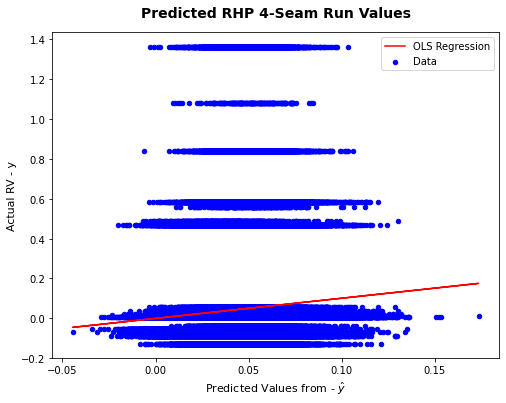

In [73]:
plt.figure(figsize = (8, 6))

plt.scatter(pred, y, s = 20, c = 'b', marker = 'o', label = 'Data')
plt.plot(pred, np.poly1d(np.polyfit(pred, y, 1))(pred), c = 'r', label = 'OLS Regression')
plt.legend()
plt.xlabel('Predicted Values from - $\hat{y}$', fontsize = 11), plt.ylabel('Actual RV - y', fontsize = 11)
plt.title('Predicted RHP 4-Seam Run Values', fontsize = 14, fontweight = 'bold', pad = 15);

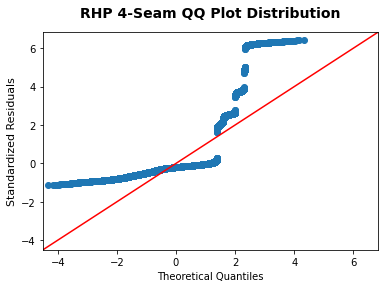

In [221]:
sm.qqplot(residuals_ff_r, line = '45', fit = True)
plt.ylabel('Standardized Residuals', fontsize = 11)
plt.title('RHP 4-Seam QQ Plot Distribution', fontsize = 14, fontweight = 'bold', pad = 15);

### RHP 4-Seam RV by Velo & Spin Rate

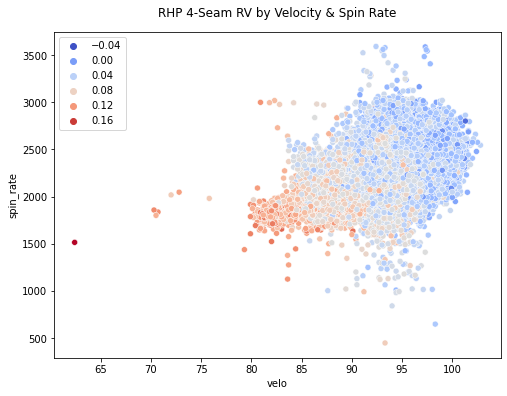

In [222]:
plt.figure(figsize = (8, 6))

#ff_r['xRV'] = pd.cut(ff_r['pred_rv'], [-0.2, 0, 10], labels = ['-0.2', '0.2'])
sns.scatterplot(data = ff_r, x = 'velo', y = 'spin_rate', hue = pred,
                palette = 'coolwarm')
plt.title('RHP 4-Seam RV by Velocity & Spin Rate', pad = 15);

### RHP 4-Seam RV by Release Extension

In [224]:
#plt.figure(figsize = (8, 6))
#
#sns.scatterplot(data = ff_r, x = 'release_extension', y = 'release_pos_z', hue = pred, palette = 'coolwarm')
#plt.xlim(0, 8.75), plt.ylim(0, 7.75)
#plt.gca().add_patch(Rectangle((0, .74), .24, .24, fill = True, fc = 'white', ec = 'black', linewidth = 2))
#plt.fill_between((7.75, 0), (0, 1), color = 'brown', alpha = .8)
##plt.legend(bbox_to_anchor = (1.15, .65))
#plt.title('RHP 4-Seam RV by Release Extension - Side View', pad = 15);

### RHP 4-Seam RV by Release Point

In [76]:
plt.figure(figsize = (8, 6))

sns.scatterplot(data = ff_r, x = 'release_pos_x', y = 'release_pos_z', hue = pred_ff_r, palette = 'coolwarm')
plt.xlim(-5, 5), plt.ylim(-0.25, 8.25)
plt.axvline(0, color = 'black'), plt.axhline(0, color = 'black')
left, bottom, width, height = (-.83, 1.59, 1.66, 1.82)
plt.gca().add_patch(Rectangle((left, bottom), width, height, fill = False, color = 'black', linewidth = 2))
# rect = mpatches.Rectangle((left, bottom), width, height, fill = False, color = 'black', linewidth = 2)
# plt.gca().add_patch(rect)
plt.title('RHP 4-Seam RV by Release Position from Hitter Perspective', pad = 15);

ValueError: Length of ndarray vectors must match length of `data` when both are used, but `data` has length 176377 and the vector passed to `hue` has length 44095.

<Figure size 576x432 with 0 Axes>

### RHP 4-Seam RV by HB & VB

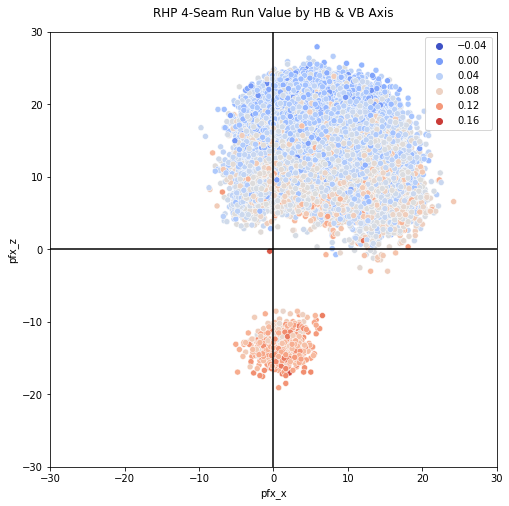

In [226]:
plt.figure(figsize = (8, 8))

sns.scatterplot(data = ff_r, x = 'pfx_x', y = 'pfx_z', hue = pred, palette = 'coolwarm') 
                # hue_norm = (-.1, 0.223))
plt.xlim(-30, 30), plt.ylim(-30, 30)
plt.axhline(0, color = 'black'), plt.axvline(0, color = 'black')
plt.title('RHP 4-Seam Run Value by HB & VB Axis', pad = 15);

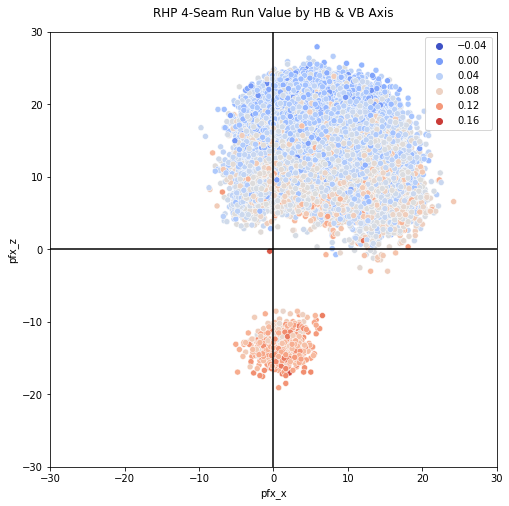

In [227]:
plt.figure(figsize = (8, 8))

sns.scatterplot(data = ff_r, x = 'pfx_x', y = 'pfx_z', hue = pred, palette = 'coolwarm') 
# hue_norm = (-.1, 0.223))
plt.xlim(-30, 30), plt.ylim(-30, 30)
plt.axhline(0, color = 'black'), plt.axvline(0, color = 'black')
plt.title('RHP 4-Seam Run Value by HB & VB Axis', pad = 15);

### RHP 4-Seam RV by Strike Zone

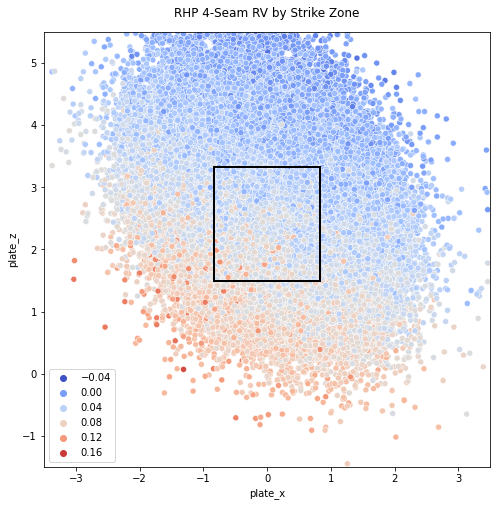

In [228]:
plt.figure(figsize = (8, 8))

sns.scatterplot(data = ff_r, x = 'plate_x', y = 'plate_z', hue = pred, palette = 'coolwarm')
plt.xlim(-3.5, 3.5), plt.ylim(-1.5, 5.5)
plt.gca().add_patch(Rectangle((-.83, 1.5), 1.66, 1.82, fill = False, color = 'black', linewidth = 2))
plt.title('RHP 4-Seam RV by Strike Zone', pad = 15);

# Random Forest Regression

## RHP 4-Seam

In [235]:
#params = {
#    'max_depth': [None, 5, 6, 7],
#    'min_samples_leaf': [1, 2, 3, 4],
#    'n_estimators': [75, 100, 125]
#}
#
#gs = GridSearchCV(rf, param_grid = params)
#gs.fit(X_train, y_train)
#pred_ff_r = gs.predict(X_test)
#print(gs.best_score_)
#print('Best Params:', gs.best_params_)

In [239]:
X = features_ff_r.drop(columns = ['rv_rel_outs'])
y = features_ff_r['rv_rel_outs']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 6)

rf = RandomForestRegressor()
rf.fit(X_train, y_train)
pred_ff_r = rf.predict(X_test)
pred = rf.predict(X)
score = cross_val_score(rf, X_test, y_test).mean()

print('R2:', round(score, 3))
print('RMSE:', round(np.sqrt(metrics.mean_squared_error(y_test, pred_ff_r)), 3))
print('MAE:', round(metrics.mean_absolute_error(y_test, pred_ff_r), 3))
print('velo, spin_rate, pfx_x, pfx_z, release_pos_x, release_pos_z, plate_x, plate_z', rf.feature_importances_)

R2: -0.035
RMSE: 0.217
MAE: 0.121
velo, spin_rate, pfx_x, pfx_z, release_pos_x, release_pos_z, plate_x, plate_z [0.10863732 0.14717183 0.12233281 0.1083721  0.1347872  0.12817198
 0.12432047 0.12620628]


In [241]:
print('R2 Train Score:', round(cross_val_score(rf, X_train, y_train).mean(), 3))

R2 Train Score: -0.027


In [ ]:
pred = gs.predict(test[X])
ff_r['xRV'] = pred
ff_r.head()

## 4-Seam LHP

In [108]:
features_ff_l = ff_l.select_dtypes([np.number])
X = features_ff_l.drop(columns = ['rv'])
X = sm.add_constant(X)
y = features_ff_l['rv']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 10)

ols_ff_l = sm.OLS(y_train, X_train).fit()
pred_ff_l = ols_ff_l.predict(X_test)
pred = ols_ff_l.predict(X_train)
fitted_vals_ff_l = ols_ff_l.fittedvalues
residuals_ff_l = ols_ff_l.resid

print('MSE:', round(metrics.mean_squared_error(y_test, pred_ff_l), 4))
print('RMSE:', round(np.sqrt(metrics.mean_squared_error(y_test, pred_ff_l)), 4))
print('MAE:', round(metrics.mean_absolute_error(y_test, pred_ff_l), 4))
print('Train MSE:', round(metrics.mean_squared_error(y_train, pred), 4))
print('Train RMSE:', round(np.sqrt(metrics.mean_squared_error(y_train, pred)), 4))
print('Train MAE:', round(metrics.mean_absolute_error(y_train, pred), 4))
print(ols_ff_l.summary())

MSE: 0.0319
RMSE: 0.1786
MAE: 0.0928
Train MSE: 0.0327
Train RMSE: 0.1809
Train MAE: 0.0939
                            OLS Regression Results                            
Dep. Variable:                     rv   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     35.27
Date:                Fri, 18 Mar 2022   Prob (F-statistic):           7.98e-63
Time:                        20:01:54   Log-Likelihood:                 15996.
No. Observations:               54977   AIC:                        -3.197e+04
Df Residuals:                   54967   BIC:                        -3.188e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------

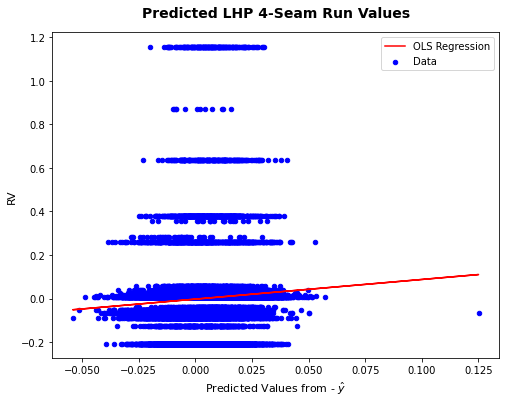

In [109]:
plt.figure(figsize = (8, 6))

plt.scatter(pred_ff_l, y_test, s = 20, c = 'b', marker = 'o', label = 'Data')
plt.plot(pred_ff_l, np.poly1d(np.polyfit(pred_ff_l, y_test, 1))(pred_ff_l), c = 'r', label = 'OLS Regression')
plt.legend()
plt.xlabel('Predicted Values from - $\hat{y}$', fontsize = 11), plt.ylabel('Actual RV - y', fontsize = 11)
plt.title('Predicted LHP 4-Seam Run Values', fontsize = 14, fontweight = 'bold', pad = 15);

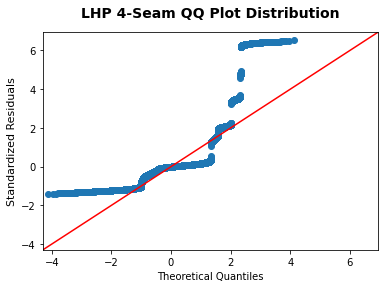

In [110]:
sm.qqplot(residuals_ff_l, line = '45', fit = True)
plt.ylabel('Actual Quantiles') # , fontsize = 10
plt.title('LHP 4-Seam QQ Plot Distribution', fontsize = 14, fontweight = 'bold', pad = 15);

## Cutter RHP

In [112]:
features_fc_r = fc_r.select_dtypes([np.number])
X = features_fc_r.drop(columns = ['rv'])
X = sm.add_constant(X)
y = features_fc_r['rv']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 10)

ols_fc_r = sm.OLS(y_train, X_train).fit()
pred_fc_r = ols_fc_r.predict(X_test)
pred = ols_fc_r.predict(X_train)
fitted_vals_fc_r = ols_fc_r.fittedvalues
residuals_fc_r = ols_fc_r.resid

print('MSE:', round(metrics.mean_squared_error(y_test, pred_fc_r), 4))
print('RMSE:', round(np.sqrt(metrics.mean_squared_error(y_test, pred_fc_r)), 4))
print('MAE:', round(metrics.mean_absolute_error(y_test, pred_fc_r), 4))
print('Train MSE:', round(metrics.mean_squared_error(y_train, pred), 4))
print('Train RMSE:', round(np.sqrt(metrics.mean_squared_error(y_train, pred)), 4))
print('Train MAE:', round(metrics.mean_absolute_error(y_train, pred), 4))
print(ols_fc_r.summary())

MSE: 0.0332
RMSE: 0.1821
MAE: 0.0945
Train MSE: 0.0313
Train RMSE: 0.1769
Train MAE: 0.091
                            OLS Regression Results                            
Dep. Variable:                     rv   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     5.928
Date:                Fri, 18 Mar 2022   Prob (F-statistic):           2.56e-08
Time:                        20:02:14   Log-Likelihood:                 7327.2
No. Observations:               23385   AIC:                        -1.463e+04
Df Residuals:                   23375   BIC:                        -1.455e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------

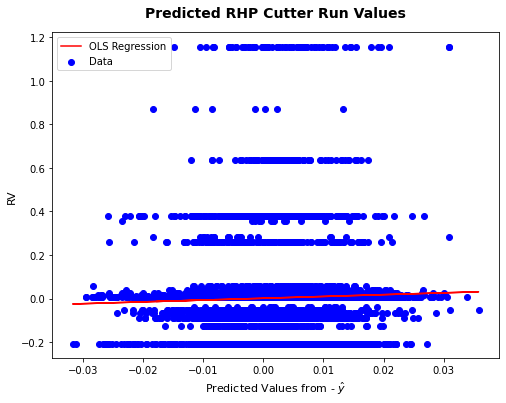

In [113]:
plt.figure(figsize = (8, 6))

plt.scatter(pred_fc_r, y_test, c = 'b', marker = 'o', label = 'Data')
plt.plot(pred_fc_r, np.poly1d(np.polyfit(pred_fc_r, y_test, 1))(pred_fc_r), c = 'r', label = 'OLS Regression')
plt.legend()
plt.xlabel('Predicted Values from - $\hat{y}$', fontsize = 11), plt.ylabel('Actual RV - y', fontsize = 11)
plt.title('Predicted RHP Cutter Run Values', fontsize = 14, fontweight = 'bold', pad = 15);

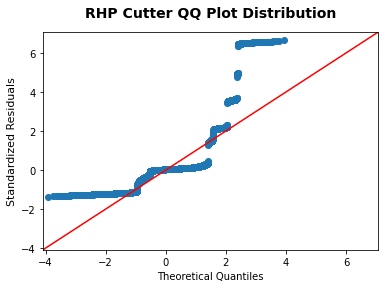

In [114]:
sm.qqplot(residuals_fc_r, line = '45', fit = True)
plt.ylabel('Actual Quantiles') # , fontsize = 10)
plt.title('RHP Cutter QQ Plot Distribution', fontsize = 14, fontweight = 'bold', pad = 15);

## Cutter LHP

In [17]:
features_fc_l = fc_l.select_dtypes([np.number])
X = features_fc_l.drop(columns = ['xRV'])
X = sm.add_constant(X)
y = features_fc_l['xRV']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 10)

ols_fc_l = sm.OLS(y_train, X_train).fit()
pred_fc_l = ols_fc_l.predict(X_test)
pred = ols_fc_l.predict(X_train)
fitted_vals_fc_l = ols_fc_l.fittedvalues
residuals_fc_l = ols_fc_l.resid

print('MSE:', round(metrics.mean_squared_error(y_test, pred_fc_l), 4))
print('RMSE:', round(np.sqrt(metrics.mean_squared_error(y_test, pred_fc_l)), 4))
print('MAE:', round(metrics.mean_absolute_error(y_test, pred_fc_l), 4))
print('Train MSE:', round(metrics.mean_squared_error(y_train, pred), 4))
print('Train RMSE:', round(np.sqrt(metrics.mean_squared_error(y_train, pred)), 4))
print('Train MAE:', round(metrics.mean_absolute_error(y_train, pred), 4))
print(ols_fc_l.summary())

MSE: 0.0033
RMSE: 0.0573
MAE: 0.0496
Train MSE: 0.0033
Train RMSE: 0.0572
Train MAE: 0.0496
                            OLS Regression Results                            
Dep. Variable:               rv_count   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     11.97
Date:                Wed, 09 Mar 2022   Prob (F-statistic):           5.30e-19
Time:                        14:38:23   Log-Likelihood:                 17591.
No. Observations:               12196   AIC:                        -3.516e+04
Df Residuals:                   12186   BIC:                        -3.509e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------

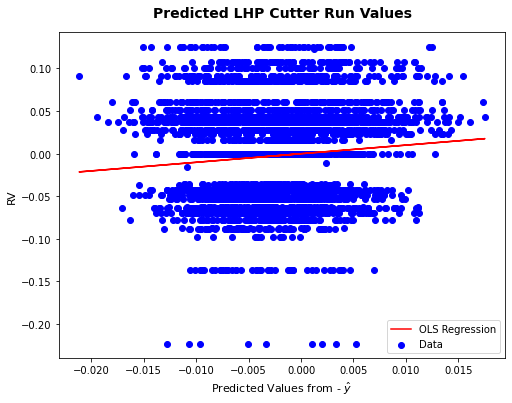

In [18]:
plt.figure(figsize = (8, 6))

plt.scatter(pred_fc_l, y_test, c = 'b', marker = 'o', label = 'Data')
plt.plot(pred_fc_l, np.poly1d(np.polyfit(pred_fc_l, y_test, 1))(pred_fc_l), c = 'r', label = 'OLS Regression')
plt.legend()
plt.xlabel('Predicted Values from - $\hat{y}$', fontsize = 11), plt.ylabel('Actual RV - y', fontsize = 11)
plt.title('Predicted LHP Cutter Run Values', fontsize = 14, fontweight = 'bold', pad = 15);

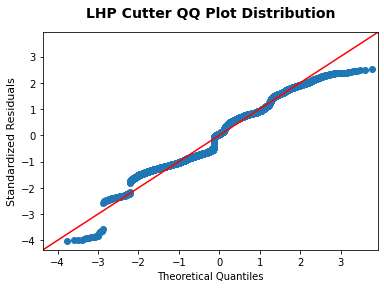

In [19]:
sm.qqplot(residuals_fc_l, line = '45', fit = True)
plt.ylabel('Actual Quantiles') # , fontsize = 10)
plt.title('LHP Cutter QQ Plot Distribution', fontsize = 14, fontweight = 'bold', pad = 15);

## Sinker RHP

In [20]:
features_si_r = si_r.select_dtypes([np.number])
X = features_si_r.drop(columns = ['xRV'])
X = sm.add_constant(X)
y = features_si_r['xRV']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 10)

ols_si_r = sm.OLS(y_train, X_train).fit()
pred_si_r = ols_si_r.predict(X_test)
pred = ols_si_r.predict(X_train)
fitted_vals_si_r = ols_si_r.fittedvalues
residuals_si_r = ols_si_r.resid

print('MSE:', round(metrics.mean_squared_error(y_test, pred_si_r), 4))
print('RMSE:', round(np.sqrt(metrics.mean_squared_error(y_test, pred_si_r)), 4))
print('MAE:', round(metrics.mean_absolute_error(y_test, pred_si_r), 4))
print('Train MSE:', round(metrics.mean_squared_error(y_train, pred), 4))
print('Train RMSE:', round(np.sqrt(metrics.mean_squared_error(y_train, pred)), 4))
print('Train MAE:', round(metrics.mean_absolute_error(y_train, pred), 4))
print(ols_si_r.summary())

MSE: 0.0036
RMSE: 0.06
MAE: 0.0516
Train MSE: 0.0036
Train RMSE: 0.0603
Train MAE: 0.0518
                            OLS Regression Results                            
Dep. Variable:               rv_count   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     13.58
Date:                Wed, 09 Mar 2022   Prob (F-statistic):           5.01e-22
Time:                        14:38:23   Log-Likelihood:                 78875.
No. Observations:               56750   AIC:                        -1.577e+05
Df Residuals:                   56740   BIC:                        -1.576e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------

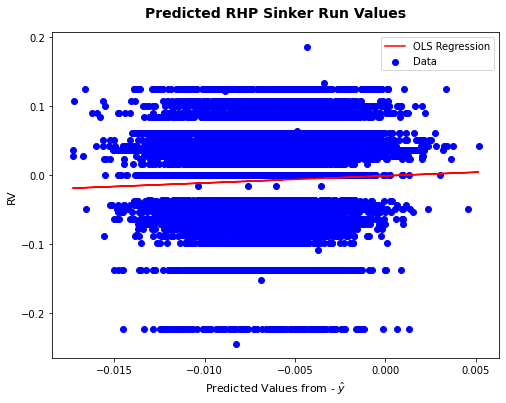

In [21]:
plt.figure(figsize = (8, 6))

plt.scatter(pred_si_r, y_test, c = 'b', marker = 'o', label = 'Data')
plt.plot(pred_si_r, np.poly1d(np.polyfit(pred_si_r, y_test, 1))(pred_si_r), c = 'r', label = 'OLS Regression')
plt.legend()
plt.xlabel('Predicted Values from - $\hat{y}$', fontsize = 11), plt.ylabel('Actual RV - y', fontsize = 11)
plt.title('Predicted RHP Sinker Run Values', fontsize = 14, fontweight = 'bold', pad = 15);

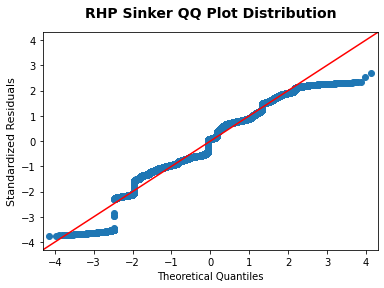

In [22]:
sm.qqplot(residuals_si_r, line = '45', fit = True)
plt.ylabel('Actual Quantiles') # , fontsize = 10)
plt.title('RHP Sinker QQ Plot Distribution', fontsize = 14, fontweight = 'bold', pad = 15);

## Sinker LHP

In [23]:
features_si_l = si_l.select_dtypes([np.number])
X = features_si_l.drop(columns = ['xRV'])
X = sm.add_constant(X)
y = features_si_l['xRV']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 10)

ols_si_l = sm.OLS(y_train, X_train).fit()
pred_si_l = ols_si_l.predict(X_test)
pred = ols_si_l.predict(X_train)
fitted_vals_si_l = ols_si_l.fittedvalues
residuals_si_l = ols_si_l.resid

print('MSE:', round(metrics.mean_squared_error(y_test, pred_si_l), 4))
print('RMSE:', round(np.sqrt(metrics.mean_squared_error(y_test, pred_si_l)), 4))
print('MAE:', round(metrics.mean_absolute_error(y_test, pred_si_l), 4))
print('Train MSE:', round(metrics.mean_squared_error(y_train, pred), 4))
print('Train RMSE:', round(np.sqrt(metrics.mean_squared_error(y_train, pred)), 4))
print('Train MAE:', round(metrics.mean_absolute_error(y_train, pred), 4))
print(ols_si_l.summary())

MSE: 0.0036
RMSE: 0.0603
MAE: 0.0518
Train MSE: 0.0036
Train RMSE: 0.06
Train MAE: 0.0515
                            OLS Regression Results                            
Dep. Variable:               rv_count   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     8.570
Date:                Wed, 09 Mar 2022   Prob (F-statistic):           6.29e-13
Time:                        14:38:23   Log-Likelihood:                 34986.
No. Observations:               25102   AIC:                        -6.995e+04
Df Residuals:                   25092   BIC:                        -6.987e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------

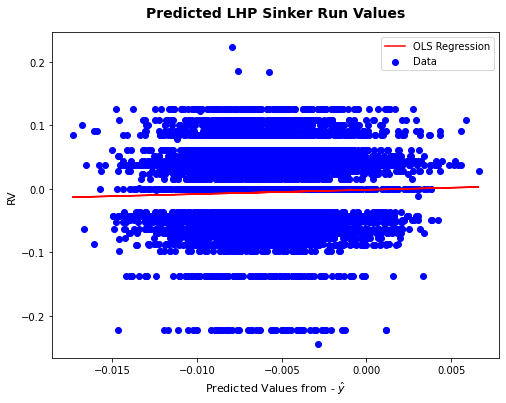

In [24]:
plt.figure(figsize = (8, 6))

plt.scatter(pred_si_l, y_test, c = 'b', marker = 'o', label = 'Data')
plt.plot(pred_si_l, np.poly1d(np.polyfit(pred_si_l, y_test, 1))(pred_si_l), c = 'r', label = 'OLS Regression')
plt.legend()
plt.xlabel('Predicted Values from - $\hat{y}$', fontsize = 11), plt.ylabel('Actual RV - y', fontsize = 11)
plt.title('Predicted LHP Sinker Run Values', fontsize = 14, fontweight = 'bold', pad = 15);

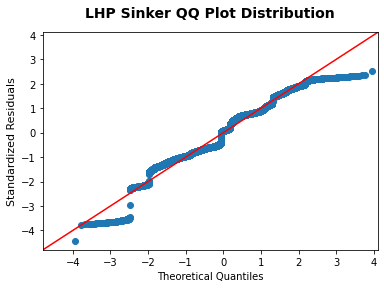

In [25]:
sm.qqplot(residuals_si_l, line = '45', fit = True)
plt.ylabel('Actual Quantiles') # , fontsize = 10
plt.title('LHP Sinker QQ Plot Distribution', fontsize = 14, fontweight = 'bold', pad = 15);

## Slider RHP

In [26]:
features_sl_r = sl_r.select_dtypes([np.number])
X = features_sl_r.drop(columns = ['xRV'])
X = sm.add_constant(X)
y = features_sl_r['xRV']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 10)

ols_sl_r = sm.OLS(y_train, X_train).fit()
pred_sl_r = ols_sl_r.predict(X_test)
pred = ols_sl_r.predict(X_train)
fitted_vals_sl_r = ols_sl_r.fittedvalues
residuals_sl_r = ols_sl_r.resid

print('MSE:', round(metrics.mean_squared_error(y_test, pred_sl_r), 4))
print('RMSE:', round(np.sqrt(metrics.mean_squared_error(y_test, pred_sl_r)), 4))
print('MAE:', round(metrics.mean_absolute_error(y_test, pred_sl_r), 4))
print('Train MSE:', round(metrics.mean_squared_error(y_train, pred), 4))
print('Train RMSE:', round(np.sqrt(metrics.mean_squared_error(y_train, pred)), 4))
print('Train MAE:', round(metrics.mean_absolute_error(y_train, pred), 4))
print(ols_sl_r.summary())

MSE: 0.0031
RMSE: 0.0555
MAE: 0.0469
Train MSE: 0.0031
Train RMSE: 0.0555
Train MAE: 0.0471
                            OLS Regression Results                            
Dep. Variable:               rv_count   R-squared:                       0.045
Model:                            OLS   Adj. R-squared:                  0.045
Method:                 Least Squares   F-statistic:                     392.7
Date:                Wed, 09 Mar 2022   Prob (F-statistic):               0.00
Time:                        14:38:24   Log-Likelihood:             1.1123e+05
No. Observations:               75569   AIC:                        -2.224e+05
Df Residuals:                   75559   BIC:                        -2.224e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------

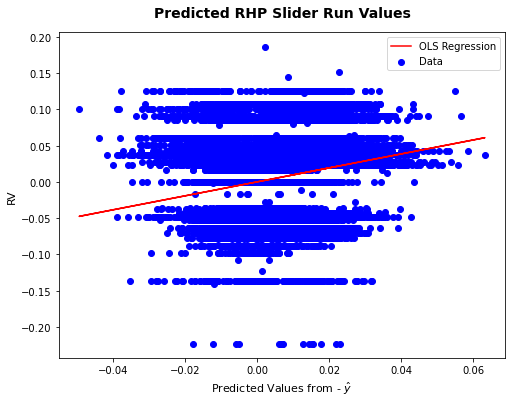

In [27]:
plt.figure(figsize = (8, 6))

plt.scatter(pred_sl_r, y_test, c = 'b', marker = 'o', label = 'Data')
plt.plot(pred_sl_r, np.poly1d(np.polyfit(pred_sl_r, y_test, 1))(pred_sl_r), c = 'r', label = 'OLS Regression')
plt.legend()
plt.xlabel('Predicted Values from - $\hat{y}$', fontsize = 11), plt.ylabel('Actual RV - y', fontsize = 11)
plt.title('Predicted RHP Slider Run Values', fontsize = 14, fontweight = 'bold', pad = 15);

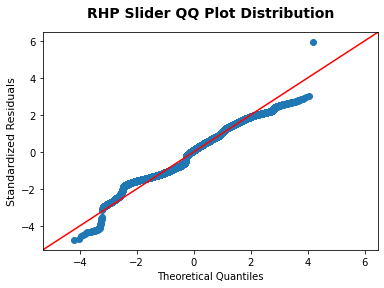

In [28]:
sm.qqplot(residuals_sl_r, line = '45', fit = True)
plt.ylabel('Actual Quantiles') # , fontsize = 10
plt.title('RHP Slider QQ Plot Distribution', fontsize = 14, fontweight = 'bold', pad = 15);

## Slider LHP

In [29]:
features_sl_l = sl_l.select_dtypes([np.number])
X = features_sl_l.drop(columns = ['xRV'])
X = sm.add_constant(X)
y = features_sl_l['xRV']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 10)

ols_sl_l = sm.OLS(y_train, X_train).fit()
pred_sl_l = ols_sl_l.predict(X_test)
pred = ols_sl_l.predict(X_train)
fitted_vals_sl_l = ols_sl_l.fittedvalues
residuals_sl_l = ols_sl_l.resid

print('MSE:', round(metrics.mean_squared_error(y_test, pred_sl_l), 4))
print('RMSE:', round(np.sqrt(metrics.mean_squared_error(y_test, pred_sl_l)), 4))
print('MAE:', round(metrics.mean_absolute_error(y_test, pred_sl_l), 4))
print('Train MSE:', round(metrics.mean_squared_error(y_train, pred), 4))
print('Train RMSE:', round(np.sqrt(metrics.mean_squared_error(y_train, pred)), 4))
print('Train MAE:', round(metrics.mean_absolute_error(y_train, pred), 4))
print(ols_sl_l.summary())

MSE: 0.0031
RMSE: 0.0554
MAE: 0.047
Train MSE: 0.0031
Train RMSE: 0.0556
Train MAE: 0.0471
                            OLS Regression Results                            
Dep. Variable:               rv_count   R-squared:                       0.042
Model:                            OLS   Adj. R-squared:                  0.041
Method:                 Least Squares   F-statistic:                     125.8
Date:                Wed, 09 Mar 2022   Prob (F-statistic):          7.29e-233
Time:                        14:38:24   Log-Likelihood:                 38342.
No. Observations:               26085   AIC:                        -7.666e+04
Df Residuals:                   26075   BIC:                        -7.658e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------

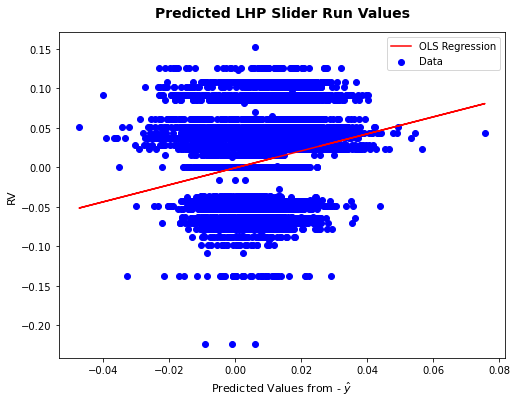

In [30]:
plt.figure(figsize = (8, 6))

plt.scatter(pred_sl_l, y_test, c = 'b', marker = 'o', label = 'Data')
plt.plot(pred_sl_l, np.poly1d(np.polyfit(pred_sl_l, y_test, 1))(pred_sl_l), c = 'r', label = 'OLS Regression')
plt.legend()
plt.xlabel('Predicted Values from - $\hat{y}$', fontsize = 11), plt.ylabel('Actual RV - y', fontsize = 11)
plt.title('Predicted LHP Slider Run Values', fontsize = 14, fontweight = 'bold', pad = 15);

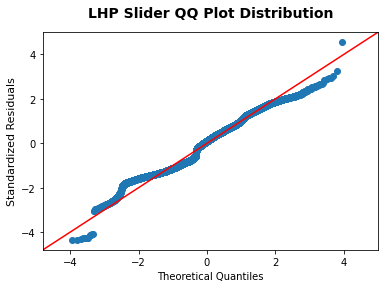

In [31]:
sm.qqplot(residuals_sl_l, line = '45', fit = True)

plt.ylabel('Actual Quantiles') # , fontsize = 10)
plt.title('LHP Slider QQ Plot Distribution', fontsize = 14, fontweight = 'bold', pad = 15);

## Curveball RHP

In [32]:
features_cu_r = cu_r.select_dtypes([np.number])
X = features_cu_r.drop(columns = ['xRV'])
X = sm.add_constant(X)
y = features_cu_r['xRV']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 10)

ols_cu_r = sm.OLS(y_train, X_train).fit()
pred_cu_r = ols_cu_r.predict(X_test)
pred = ols_cu_r.predict(X_train)
fitted_vals_cu_r = ols_cu_r.fittedvalues
residuals_cu_r = ols_cu_r.resid

print('MSE:', round(metrics.mean_squared_error(y_test, pred_cu_r), 4))
print('RMSE:', round(np.sqrt(metrics.mean_squared_error(y_test, pred_cu_r)), 4))
print('MAE:', round(metrics.mean_absolute_error(y_test, pred_cu_r), 4))
print('Train MSE:', round(metrics.mean_squared_error(y_train, pred), 4))
print('Train RMSE:', round(np.sqrt(metrics.mean_squared_error(y_train, pred)), 4))
print('Train MAE:', round(metrics.mean_absolute_error(y_train, pred), 4))
print(ols_cu_r.summary())

MSE: 0.0028
RMSE: 0.0525
MAE: 0.0448
Train MSE: 0.0028
Train RMSE: 0.0529
Train MAE: 0.045
                            OLS Regression Results                            
Dep. Variable:               rv_count   R-squared:                       0.035
Model:                            OLS   Adj. R-squared:                  0.034
Method:                 Least Squares   F-statistic:                     119.2
Date:                Wed, 09 Mar 2022   Prob (F-statistic):          3.91e-221
Time:                        14:38:25   Log-Likelihood:                 45618.
No. Observations:               29991   AIC:                        -9.122e+04
Df Residuals:                   29981   BIC:                        -9.113e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------

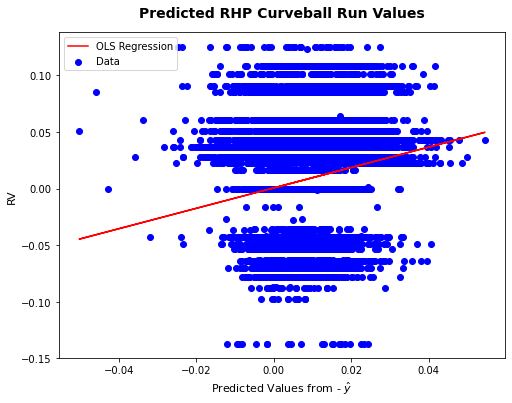

In [33]:
plt.figure(figsize = (8, 6))

plt.scatter(pred_cu_r, y_test, c = 'b', marker = 'o', label = 'Data')
plt.plot(pred_cu_r, np.poly1d(np.polyfit(pred_cu_r, y_test, 1))(pred_cu_r), c = 'r', label = 'OLS Regression')
plt.legend()
plt.xlabel('Predicted Values from - $\hat{y}$', fontsize = 11), plt.ylabel('Actual RV - y', fontsize = 11)
plt.title('Predicted RHP Curveball Run Values', fontsize = 14, fontweight = 'bold', pad = 15);

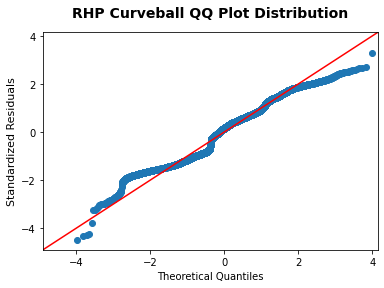

In [34]:
sm.qqplot(residuals_cu_r, line='45', fit=True)
plt.ylabel('Actual Quantiles') # , fontsize = 10
plt.title('RHP Curveball QQ Plot Distribution', fontsize = 14, fontweight = 'bold', pad = 15);

## Curveball LHP

In [35]:
features_cu_l = cu_l.select_dtypes([np.number])
X = features_cu_l.drop(columns = ['xRV'])
X = sm.add_constant(X)
y = features_cu_l['xRV']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 10)

ols_cu_l = sm.OLS(y_train, X_train).fit()
pred_cu_l = ols_cu_l.predict(X_test)
pred = ols_cu_l.predict(X_train)
fitted_vals_cu_l = ols_cu_l.fittedvalues
residuals_cu_l = ols_cu_l.resid

print('MSE:', round(metrics.mean_squared_error(y_test, pred_cu_l), 4))
print('RMSE:', round(np.sqrt(metrics.mean_squared_error(y_test, pred_cu_l)), 4))
print('MAE:', round(metrics.mean_absolute_error(y_test, pred_cu_l), 4))
print('Train MSE:', round(metrics.mean_squared_error(y_train, pred), 4))
print('Train RMSE:', round(np.sqrt(metrics.mean_squared_error(y_train, pred)), 4))
print('Train MAE:', round(metrics.mean_absolute_error(y_train, pred), 4))
print(ols_cu_l.summary())

MSE: 0.0028
RMSE: 0.0527
MAE: 0.0447
Train MSE: 0.0028
Train RMSE: 0.0531
Train MAE: 0.0451
                            OLS Regression Results                            
Dep. Variable:               rv_count   R-squared:                       0.030
Model:                            OLS   Adj. R-squared:                  0.029
Method:                 Least Squares   F-statistic:                     48.00
Date:                Wed, 09 Mar 2022   Prob (F-statistic):           4.73e-86
Time:                        14:38:25   Log-Likelihood:                 21360.
No. Observations:               14084   AIC:                        -4.270e+04
Df Residuals:                   14074   BIC:                        -4.262e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------

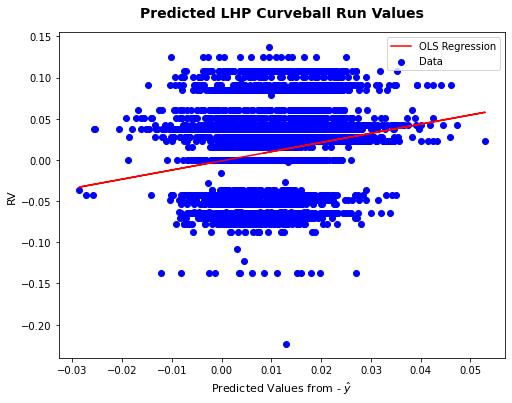

In [36]:
plt.figure(figsize = (8, 6))

plt.scatter(pred_cu_l, y_test, c = 'b', marker = 'o', label = 'Data')
plt.plot(pred_cu_l, np.poly1d(np.polyfit(pred_cu_l, y_test, 1))(pred_cu_l), c = 'r', label = 'OLS Regression')
plt.legend()
plt.xlabel('Predicted Values from - $\hat{y}$', fontsize = 11), plt.ylabel('Actual RV - y', fontsize = 11)
plt.title('Predicted LHP Curveball Run Values', fontsize = 14, fontweight = 'bold', pad = 15);

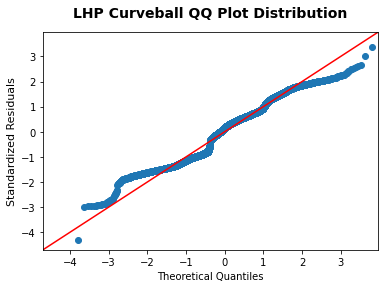

In [37]:
sm.qqplot(residuals_cu_l, line='45', fit=True)
plt.ylabel('Actual Quantiles') # , fontsize = 10)
plt.title('LHP Curveball QQ Plot Distribution', fontsize = 14, fontweight = 'bold', pad = 15);

## Changeup RHP

In [38]:
features_ch_r = ch_r.select_dtypes([np.number])
X = features_ch_r.drop(columns = ['xRV'])
X = sm.add_constant(X)
y = features_ch_r['xRV']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 10)

ols_ch_r = sm.OLS(y_train, X_train).fit()
pred_ch_r = ols_ch_r.predict(X_test)
pred = ols_ch_r.predict(X_train)
fitted_vals_ch_r = ols_ch_r.fittedvalues
residuals_ch_r = ols_ch_r.resid

print('MSE:', round(metrics.mean_squared_error(y_test, pred_ch_r), 4))
print('RMSE:', round(np.sqrt(metrics.mean_squared_error(y_test, pred_ch_r)), 4))
print('MAE:', round(metrics.mean_absolute_error(y_test, pred_ch_r), 4))
print('Train MSE:', round(metrics.mean_squared_error(y_train, pred), 4))
print('Train RMSE:', round(np.sqrt(metrics.mean_squared_error(y_train, pred)), 4))
print('Train MAE:', round(metrics.mean_absolute_error(y_train, pred), 4))
print(ols_ch_r.summary())

MSE: 0.0032
RMSE: 0.0562
MAE: 0.0475
Train MSE: 0.0032
Train RMSE: 0.0565
Train MAE: 0.0479
                            OLS Regression Results                            
Dep. Variable:               rv_count   R-squared:                       0.043
Model:                            OLS   Adj. R-squared:                  0.042
Method:                 Least Squares   F-statistic:                     187.9
Date:                Wed, 09 Mar 2022   Prob (F-statistic):               0.00
Time:                        14:38:25   Log-Likelihood:                 55228.
No. Observations:               37989   AIC:                        -1.104e+05
Df Residuals:                   37979   BIC:                        -1.104e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------

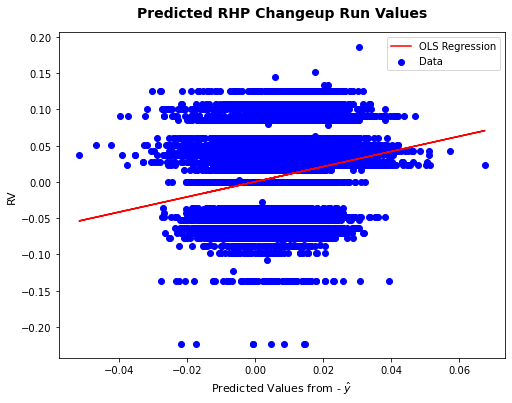

In [39]:
plt.figure(figsize = (8, 6))
plt.scatter(pred_ch_r, y_test, c = 'b', marker = 'o', label = 'Data')
plt.plot(pred_ch_r, np.poly1d(np.polyfit(pred_ch_r, y_test, 1))(pred_ch_r), c = 'r', label = 'OLS Regression')
plt.legend()
plt.xlabel('Predicted Values from - $\hat{y}$', fontsize = 11), plt.ylabel('Actual RV - y', fontsize = 11)
plt.title('Predicted RHP Changeup Run Values', fontsize = 14, fontweight = 'bold', pad = 15);

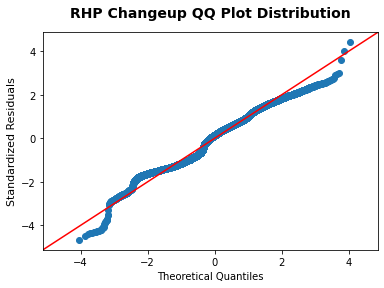

In [40]:
sm.qqplot(residuals_ch_r, line = '45', fit = True)
plt.ylabel('Actual Quantiles') # , fontsize = 10)
plt.title('RHP Changeup QQ Plot Distribution', fontsize = 14, fontweight = 'bold', pad = 15);

## Changeup LHP

In [41]:
features_ch_l = ch_l.select_dtypes([np.number])
X = features_ch_l.drop(columns = ['xRV'])
X = sm.add_constant(X)
y = features_ch_l['xRV']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 10)

ols_ch_l = sm.OLS(y_train, X_train).fit()
pred_ch_l = ols_ch_l.predict(X_test)
pred = ols_ch_l.predict(X_train)
fitted_vals_ch_l = ols_ch_l.fittedvalues
residuals_ch_l = ols_ch_l.resid

print('MSE:', round(metrics.mean_squared_error(y_test, pred_ch_l), 4))
print('RMSE:', round(np.sqrt(metrics.mean_squared_error(y_test, pred_ch_l)), 4))
print('MAE:', round(metrics.mean_absolute_error(y_test, pred_ch_l), 4))
print('Train MSE:', round(metrics.mean_squared_error(y_train, pred), 4))
print('Train RMSE:', round(np.sqrt(metrics.mean_squared_error(y_train, pred)), 4))
print('Train MAE:', round(metrics.mean_absolute_error(y_train, pred), 4))
print(ols_ch_l.summary())

MSE: 0.0031
RMSE: 0.0557
MAE: 0.0465
Train MSE: 0.0031
Train RMSE: 0.0555
Train MAE: 0.0466
                            OLS Regression Results                            
Dep. Variable:               rv_count   R-squared:                       0.061
Model:                            OLS   Adj. R-squared:                  0.060
Method:                 Least Squares   F-statistic:                     159.4
Date:                Wed, 09 Mar 2022   Prob (F-statistic):          9.78e-294
Time:                        14:38:26   Log-Likelihood:                 32778.
No. Observations:               22251   AIC:                        -6.554e+04
Df Residuals:                   22241   BIC:                        -6.546e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------

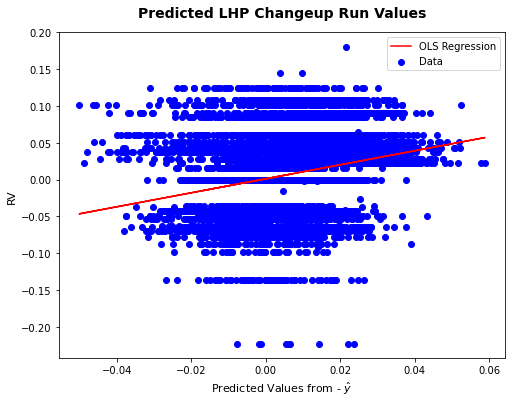

In [42]:
plt.figure(figsize = (8, 6))
plt.scatter(pred_ch_l, y_test, c = 'b', marker = 'o', label = 'Data')
plt.plot(pred_ch_l, np.poly1d(np.polyfit(pred_ch_l, y_test, 1))(pred_ch_l), c = 'r', label = 'OLS Regression')
plt.legend()
plt.xlabel('Predicted Values from - $\hat{y}$', fontsize = 11), plt.ylabel('Actual RV - y', fontsize = 11)
plt.title('Predicted LHP Changeup Run Values', fontsize = 14, fontweight = 'bold', pad = 15);

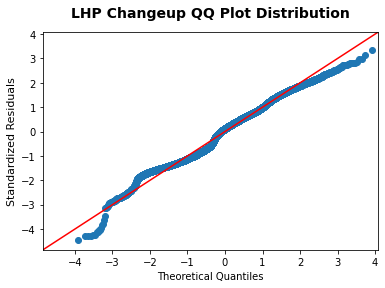

In [43]:
sm.qqplot(residuals_ch_l, line = '45', fit = True)
plt.ylabel('Actual Quantiles') # , fontsize = 10
plt.title('LHP Changeup QQ Plot Distribution', fontsize = 14, fontweight = 'bold', pad = 15);

# Grouped Pitches

## Fastball RHP

#### 4-Seam, Cutter, Sinker

In [44]:
features_fastball_r = rhp_fastball.select_dtypes([np.number])
X = features_fastball_r.drop(columns = ['xRV'])
X = sm.add_constant(X)
y = features_fastball_r['xRV']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 10)

ols_fastball_r = sm.OLS(y_train, X_train).fit()
pred_fastball_r = ols_fastball_r.predict(X_test)
fitted_vals_fastball_r = ols_fastball_r.fittedvalues
residuals_fastball_r = ols_fastball_r.resid

print('MSE:', round(metrics.mean_squared_error(y_test, pred_fastball_r), 4))
print('RMSE:', round(np.sqrt(metrics.mean_squared_error(y_test, pred_fastball_r)), 4))
print('MAE:', round(metrics.mean_absolute_error(y_test, pred_fastball_r), 4))
print(ols_fastball_r.summary())

MSE: 0.0036
RMSE: 0.06
MAE: 0.0512
                            OLS Regression Results                            
Dep. Variable:               rv_count   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     194.6
Date:                Wed, 09 Mar 2022   Prob (F-statistic):               0.00
Time:                        14:38:26   Log-Likelihood:             2.9544e+05
No. Observations:              212418   AIC:                        -5.909e+05
Df Residuals:                  212408   BIC:                        -5.908e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
con

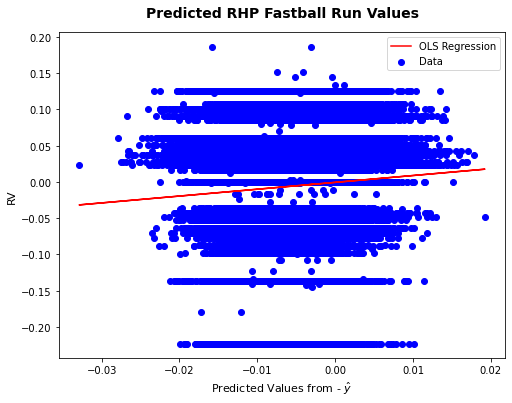

In [45]:
plt.figure(figsize = (8, 6))
plt.scatter(pred_fastball_r, y_test, c = 'b', marker = 'o', label = 'Data')
plt.plot(pred_fastball_r, np.poly1d(np.polyfit(pred_fastball_r, y_test, 1))(pred_fastball_r), c = 'r',
         label = 'OLS Regression')
plt.legend()
plt.xlabel('Predicted Values from - $\hat{y}$', fontsize = 11), plt.ylabel('Actual RV - y', fontsize = 11)
plt.title('Predicted RHP Fastball Run Values', fontsize = 14, fontweight = 'bold', pad = 15);

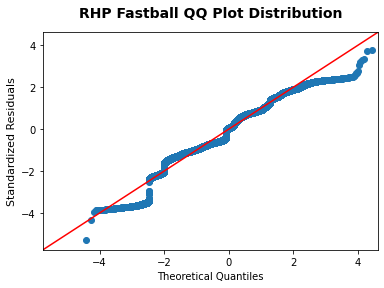

In [46]:
sm.qqplot(residuals_fastball_r, line = '45', fit = True)

plt.ylabel('Actual Quantiles') # , fontsize = 10)
plt.title('RHP Fastball QQ Plot Distribution', fontsize = 14, fontweight = 'bold', pad = 15);

## Fastball LHP

#### 4-Seam, Cutter, Sinker

In [47]:
features_fastball_l = lhp_fastball.select_dtypes([np.number])
X = features_fastball_l.drop(columns = ['xRV'])
X = sm.add_constant(X)
y = features_fastball_l['xRV']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 10)

ols_fastball_l = sm.OLS(y_train, X_train).fit()
pred_fastball_l = ols_fastball_l.predict(X_test)
fitted_vals_fastball_l = ols_fastball_l.fittedvalues
residuals_fastball_l = ols_fastball_l.resid

print('MSE:', round(metrics.mean_squared_error(y_test, pred_fastball_l), 4))
print('RMSE:', round(np.sqrt(metrics.mean_squared_error(y_test, pred_fastball_l)), 4))
print('MAE:', round(metrics.mean_absolute_error(y_test, pred_fastball_l), 4))
print(ols_fastball_l.summary())

MSE: 0.0036
RMSE: 0.0601
MAE: 0.0512
                            OLS Regression Results                            
Dep. Variable:               rv_count   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     68.98
Date:                Wed, 09 Mar 2022   Prob (F-statistic):          1.97e-127
Time:                        14:38:27   Log-Likelihood:             1.2839e+05
No. Observations:               92276   AIC:                        -2.568e+05
Df Residuals:                   92266   BIC:                        -2.567e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
c

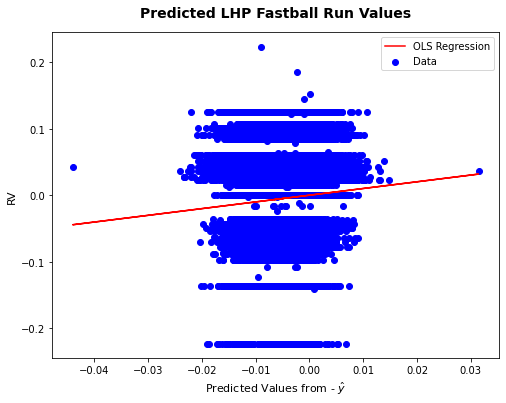

In [48]:
plt.figure(figsize = (8, 6))
plt.scatter(pred_fastball_l, y_test, c = 'b', marker = 'o', label = 'Data')
plt.plot(pred_fastball_l, np.poly1d(np.polyfit(pred_fastball_l, y_test, 1))(pred_fastball_l), c = 'r', 
         label = 'OLS Regression')
plt.legend()
plt.xlabel('Predicted Values from - $\hat{y}$', fontsize = 11), plt.ylabel('Actual RV - y', fontsize = 11)
plt.title('Predicted LHP Fastball Run Values', fontsize = 14, fontweight = 'bold', pad = 15);

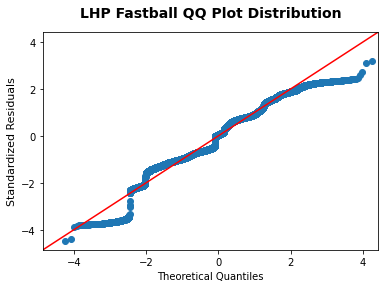

In [49]:
sm.qqplot(residuals_fastball_l, line = '45', fit = True)
plt.ylabel('Actual Quantiles') # , fontsize = 10
plt.title('LHP Fastball QQ Plot Distribution', fontsize = 14, fontweight = 'bold', pad = 15);

## Breaking Ball RHP

#### Slider, Curveball, Knuckle Curve

In [50]:
features_bb_r = rhp_breaking_ball.select_dtypes([np.number])
X = features_bb_r.drop(columns = ['xRV'])
X = sm.add_constant(X)
y = features_bb_r['xRV']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 10)

ols_bb_r = sm.OLS(y_train, X_train).fit()
pred_bb_r = ols_bb_r.predict(X_test)
fitted_vals_bb_r = ols_bb_r.fittedvalues
residuals_bb_r = ols_bb_r.resid

print('MSE:', round(metrics.mean_squared_error(y_test, pred_bb_r), 4))
print('RMSE:', round(np.sqrt(metrics.mean_squared_error(y_test, pred_bb_r)), 4))
print('MAE:', round(metrics.mean_absolute_error(y_test, pred_bb_r), 4))
print(ols_bb_r.summary())

MSE: 0.003
RMSE: 0.0548
MAE: 0.0465
                            OLS Regression Results                            
Dep. Variable:               rv_count   R-squared:                       0.037
Model:                            OLS   Adj. R-squared:                  0.037
Method:                 Least Squares   F-statistic:                     494.4
Date:                Wed, 09 Mar 2022   Prob (F-statistic):               0.00
Time:                        14:38:28   Log-Likelihood:             1.6977e+05
No. Observations:              114287   AIC:                        -3.395e+05
Df Residuals:                  114277   BIC:                        -3.394e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
co

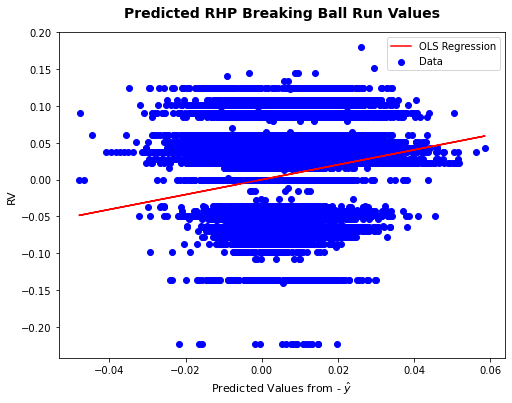

In [51]:
plt.figure(figsize = (8, 6))
plt.scatter(pred_bb_r, y_test, c = 'b', marker = 'o', label = 'Data')
plt.plot(pred_bb_r, np.poly1d(np.polyfit(pred_bb_r, y_test, 1))(pred_bb_r), c = 'r', label = 'OLS Regression')
plt.legend()
plt.xlabel('Predicted Values from - $\hat{y}$', fontsize = 11), plt.ylabel('Actual RV - y', fontsize = 11)
plt.title('Predicted RHP Breaking Ball Run Values', fontsize = 14, fontweight = 'bold', pad = 15);

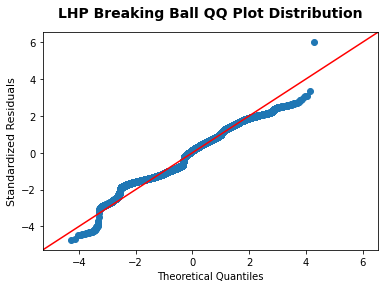

In [52]:
sm.qqplot(residuals_bb_r, line = '45', fit = True)
plt.ylabel('Actual Quantiles') # , fontsize = 10)
plt.title('LHP Breaking Ball QQ Plot Distribution', fontsize = 14, fontweight = 'bold', pad = 15);

## Breaking Ball LHP

#### Slider, Curveball, Knuckle Curve

In [53]:
features_bb_l = lhp_breaking_ball.select_dtypes([np.number])
X = features_bb_l.drop(columns = ['xRV'])
X = sm.add_constant(X)
y = features_bb_l['xRV']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 10)

ols_bb_l = sm.OLS(y_train, X_train).fit()
pred_bb_l = ols_bb_l.predict(X_test)
fitted_vals_bb_l = ols_bb_l.fittedvalues
residuals_bb_l = ols_bb_l.resid

print('MSE:', round(metrics.mean_squared_error(y_test, pred_bb_l), 4))
print('RMSE:', round(np.sqrt(metrics.mean_squared_error(y_test, pred_bb_l)), 4))
print('MAE:', round(metrics.mean_absolute_error(y_test, pred_bb_l), 4))
print(ols_bb_l.summary())

MSE: 0.003
RMSE: 0.0545
MAE: 0.0464
                            OLS Regression Results                            
Dep. Variable:               rv_count   R-squared:                       0.037
Model:                            OLS   Adj. R-squared:                  0.036
Method:                 Least Squares   F-statistic:                     175.6
Date:                Wed, 09 Mar 2022   Prob (F-statistic):               0.00
Time:                        14:38:28   Log-Likelihood:                 61949.
No. Observations:               41699   AIC:                        -1.239e+05
Df Residuals:                   41689   BIC:                        -1.238e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
co

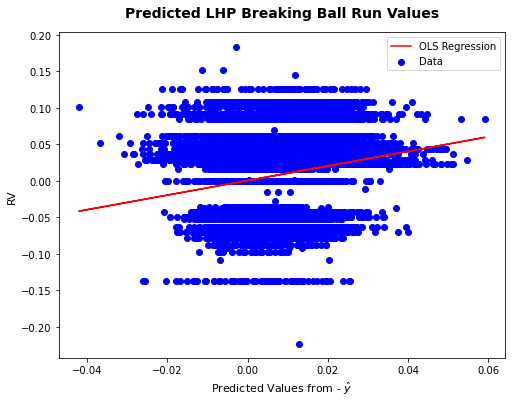

In [54]:
plt.figure(figsize = (8, 6))
plt.scatter(pred_bb_l, y_test, c = 'b', marker = 'o', label = 'Data')
plt.plot(pred_bb_l, np.poly1d(np.polyfit(pred_bb_l, y_test, 1))(pred_bb_l), c = 'r', label = 'OLS Regression')
plt.legend()
plt.xlabel('Predicted Values from - $\hat{y}$', fontsize = 11), plt.ylabel('Actual RV - y', fontsize = 11)
plt.title('Predicted LHP Breaking Ball Run Values', fontsize = 14, fontweight = 'bold', pad = 15);

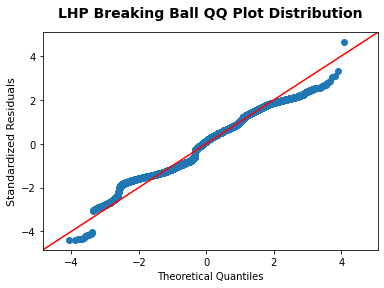

In [55]:
sm.qqplot(residuals_bb_l, line = '45', fit = True)
plt.ylabel('Actual Quantiles') # , fontsize = 10
plt.title('LHP Breaking Ball QQ Plot Distribution', fontsize = 14, fontweight = 'bold', pad = 15);

## Off-speed RHP

#### Changeup, Splitter

In [56]:
features_os_r = rhp_offspeed.select_dtypes([np.number])
X = features_os_r.drop(columns = ['xRV'])
X = sm.add_constant(X)
y = features_os_r['xRV']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 10)

ols_os_r = sm.OLS(y_train, X_train).fit()
pred_os_r = ols_os_r.predict(X_test)
fitted_vals_os_r = ols_os_r.fittedvalues
residuals_os_r = ols_os_r.resid

print('MSE:', round(metrics.mean_squared_error(y_test, pred_os_r), 4))
print('RMSE:', round(np.sqrt(metrics.mean_squared_error(y_test, pred_os_r)), 4))
print('MAE:', round(metrics.mean_absolute_error(y_test, pred_os_r), 4))
print(ols_os_r.summary())

MSE: 0.0032
RMSE: 0.0563
MAE: 0.0477
                            OLS Regression Results                            
Dep. Variable:               rv_count   R-squared:                       0.041
Model:                            OLS   Adj. R-squared:                  0.041
Method:                 Least Squares   F-statistic:                     218.5
Date:                Wed, 09 Mar 2022   Prob (F-statistic):               0.00
Time:                        14:38:29   Log-Likelihood:                 66491.
No. Observations:               45668   AIC:                        -1.330e+05
Df Residuals:                   45658   BIC:                        -1.329e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
c

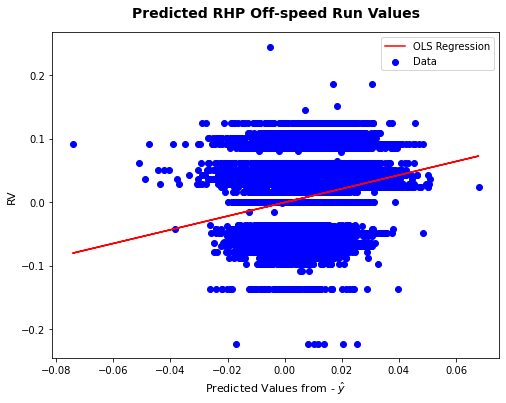

In [57]:
plt.figure(figsize = (8, 6))
plt.scatter(pred_os_r, y_test, c = 'b', marker = 'o', label = 'Data')
plt.plot(pred_os_r, np.poly1d(np.polyfit(pred_os_r, y_test, 1))(pred_os_r), c = 'r', label = 'OLS Regression')
plt.legend()
plt.xlabel('Predicted Values from - $\hat{y}$', fontsize = 11), plt.ylabel('Actual RV - y', fontsize = 11)
plt.title('Predicted RHP Off-speed Run Values', fontsize = 14, fontweight = 'bold', pad = 15);

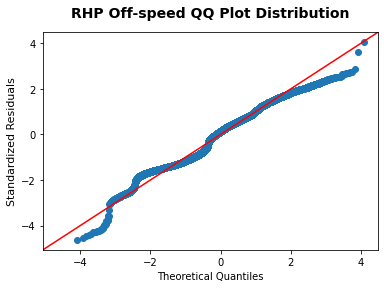

In [58]:
sm.qqplot(residuals_os_r, line = '45', fit = True)
plt.ylabel('Actual Quantiles') # , fontsize = 10)
plt.title('RHP Off-speed QQ Plot Distribution', fontsize = 14, fontweight = 'bold', pad = 15);

## Off-speed LHP

#### Changeup, Splitter

In [59]:
features_os_l = lhp_offspeed.select_dtypes([np.number])
X = features_os_l.drop(columns = ['xRV'])
X = sm.add_constant(X)
y = features_os_l['xRV']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 10)

ols_os_l = sm.OLS(y_train, X_train).fit()
pred_os_l = ols_os_l.predict(X_test)
fitted_vals_os_l = ols_os_l.fittedvalues
residuals_os_l = ols_os_l.resid

print('MSE:', round(metrics.mean_squared_error(y_test, pred_os_l), 4))
print('RMSE:', round(np.sqrt(metrics.mean_squared_error(y_test, pred_os_l)), 4))
print('MAE:', round(metrics.mean_absolute_error(y_test, pred_os_l), 4))
print(ols_os_l.summary())

MSE: 0.0031
RMSE: 0.0557
MAE: 0.0466
                            OLS Regression Results                            
Dep. Variable:               rv_count   R-squared:                       0.060
Model:                            OLS   Adj. R-squared:                  0.060
Method:                 Least Squares   F-statistic:                     160.9
Date:                Wed, 09 Mar 2022   Prob (F-statistic):          9.29e-297
Time:                        14:38:29   Log-Likelihood:                 33415.
No. Observations:               22703   AIC:                        -6.681e+04
Df Residuals:                   22693   BIC:                        -6.673e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
c

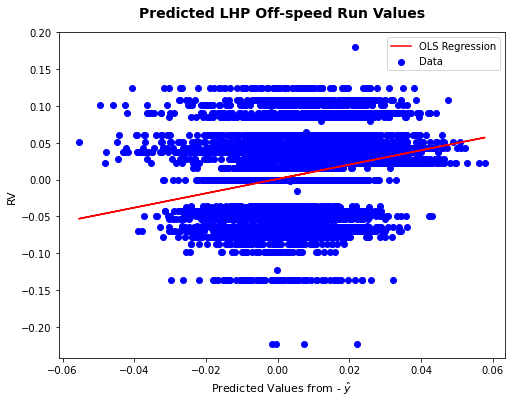

In [60]:
plt.figure(figsize = (8, 6))
plt.scatter(pred_os_l, y_test, c = 'b', marker = 'o', label = 'Data')
plt.plot(pred_os_l, np.poly1d(np.polyfit(pred_os_l, y_test, 1))(pred_os_l), c = 'r', label = 'OLS Regression')
plt.legend()
plt.xlabel('Predicted Values from - $\hat{y}$', fontsize = 11), plt.ylabel('Actual RV - y', fontsize = 11)
plt.title('Predicted LHP Off-speed Run Values', fontsize = 14, fontweight = 'bold', pad = 15);

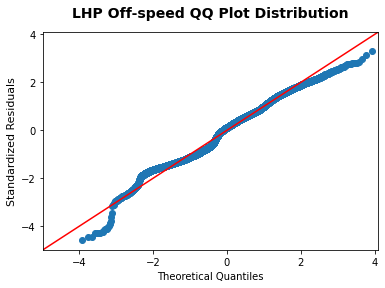

In [61]:
sm.qqplot(residuals_os_l, line = '45', fit = True)
plt.ylabel('Actual Quantiles') # , fontsize = 10)
plt.title('LHP Off-speed QQ Plot Distribution', fontsize = 14, fontweight = 'bold', pad = 15);